<a ><img src="Pictures/trashpanda.png"  width="70" align="left"> </a>
<div style="text-align: right"> <h3><span style="color:gray"> DRAFT </span> </h3> </div>

<br>
<br>
<br>

<a ><img src="Pictures/Icon.png" Width="250" align="center"> </a>

<br>
<br>



<h1><center>Sentiment Analysis</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#022F73'> Analysis of Headlines with VADER and FinBERT </font>  </span></center></h2>


<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>

<h4>About this Notebook</h4>
We will conduct a sentiment Analysis with VADER  <br> 
(Valence Aware Dictionary for Sentiment Reasoning) and FinBERT, a pre-trained Model,<br>  
on headlines of ten different news outlets and generate for each a dedicated sentiment KPI<br>
per trading day. In the end we will have a sound time series and - hopefully - some <br>
predictive results.
<br>
<br>


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="text-decoration:none; margin-top: 30px; background-color:#F2F2F2; border-color:#022F73">
    <span style="color:#022F73">
    <ol>
      <li><a href="#1"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Motivation  </span> </a></li>
      <li><a href="#2"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Sentiment Scores with pysentiment and VADER</span> </a></li>
      <li><a href="#3"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Upload on our MySQL Database</span> </a></li>
      <li><a href="#4"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Adjustments on the pre-trained BERT model </span> </a></li>
      <li><a href="#5"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Final FinBERT Model</span> </a></li>
       <li><a href="#6"> <span style="color:#022F73;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Upload on our MySQL Database</span> </a></li>
    </ol>
    </span>
</div>

In [160]:
#!pip install html5lib
#!pip install ipython-sql
#!pip install nltk

import requests
from   bs4 import BeautifulSoup
import html5lib
import time
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import dtale
import sqlalchemy
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
import pysentiment
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns

# 1. Motivation <a id="1"></a>


> <i> "There are three ways to make a living in this business: be first, be smarter, or cheat. Well, I don't cheat. And although I like to think we have some pretty smart people here in this room, it sure is a hell of lot easier to just be first." </i> **- Margin Call** 

But to be the first to use market data, you would need to be in an optimal physical location (depending on the stock exchanges) and you have to have the fastest connection. Neither of those is true for me and many others. So to be successful - in this analogy of margin call - you would have to design/manipulate a unique set of data - and therefore be first again.

## Revision of our news scraping approach

#### Documentation: https://requests.readthedocs.io/en/master/user/advanced
```j
content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))
`````


### A. Bild

In [161]:
url = "https://www.bild.de/politik/international/bild-international/home-44225950.bild.html"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [162]:
bild = BeautifulSoup(content.content, 'html.parser')

headlines = bild.find_all(attrs={'class':'headline'})

df_bild = pd.DataFrame([i.text for i in headlines], columns=["bild"])
print (df_bild.size, df_bild.head())

12                                                 bild
0                  Bill Gates on conspiracy theories
1               “Run! The planes are bombing again!”
2                             Church bombed to ruins
3  „The city looks like German cities during the ...
4          Navalny: Sanction Putin's closest circle 


### B. Spiegel

In [163]:
url = "https://www.spiegel.de/international/"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [165]:
spiegel = BeautifulSoup(content.content, 'html.parser')

headlines = spiegel.find_all(attrs={'class':'align-middle'})

df_spiegel = pd.DataFrame([i.text for i in headlines], columns=["spiegel"])
print (df_spiegel.size, df_spiegel.head())

27                                              spiegel
0  A Model African Country Slides Toward Dictator...
1                      “How Can You Not Be Worried?”
2  EU Border Agency Frontex Complicit in Greek Re...
3             If That's the Future, then Good Night!
4             "There Will Be Unrest, Dead Civilians"


### C. Zeit

In [166]:
url = "https://www.zeit.de/english/index"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [167]:
zeit = BeautifulSoup(content.content, 'html.parser')

headlines = zeit.find_all(attrs={'class':'zon-teaser-standard__title'})

df_zeit = pd.DataFrame([i.text for i in headlines], columns=["zeit"])
print (df_zeit.size, df_zeit.head())

20                                                 zeit
0                                   "It's Up To Us" 
1                   The Nightmare Has Become Reality
2  "Food Becomes Increasingly Important the More ...
3                  Exorcism in Lieu of Enlightenment
4                     "None of Us Want to Be Killed"


### D. FAZ

In [168]:
url = "https://www.faz.net/english/"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [169]:
faz = BeautifulSoup(content.content, 'html.parser')

headlines = faz.find_all(attrs={'class':'tsr-Base_HeadlineText'})

df_faz = pd.DataFrame([i.text for i in headlines], columns=["faz"]).replace("\n", "", regex=True).replace("\t", "", regex=True)
print (df_faz.size, df_faz.head())

20                                                  faz
0  „We have to fight misinformation because peopl...
1                  Do not ruin the Internet!        
2                              The Black Axe        
3  Time for a German-British Friendship Treaty   ...
4                 The Girl With The Red Coat        


### E. BBC

In [170]:
url = "https://www.bbc.com/news"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [171]:
bbc = BeautifulSoup(content.content, 'html.parser')

headlines = bbc.find_all('h3')

df_bbc = pd.DataFrame([i.text for i in headlines], columns=["bbc"])
print (df_bbc.size, df_bbc.head())

58                                                 bbc
0  Belgian doctors with Covid asked to keep working
1  Belgian doctors with Covid asked to keep working
2   Vice-president to miss Trump Supreme Court vote
3      Water on the Moon could sustain a lunar base
4  The Countdown: I am young and this is why I vote


### F. CNN

In [172]:
url = "https://www.cnn.com/business"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [173]:
cnn = BeautifulSoup(content.content, 'html.parser')

headlines = cnn.find_all(attrs={'class': 'cd__headline'})

df_cnn = pd.DataFrame([i.text for i in headlines], columns=["cnn"])
print (df_cnn.size, df_cnn.head())

35                                                  cnn
0  Trump promised to fix what he calls an unfair ...
1  Stocks post steep losses on surging Covid-19 c...
2  Jack Ma's Ant Group raises $34 billion in worl...
3  China says it will impose sanctions on Boeing ...
4  Want something delivered by Christmas? Order w...


### G. CNBC

In [174]:
url = "https://www.cnbc.com"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [175]:
cnbc = BeautifulSoup(content.content, 'html.parser')

headlines = cnbc.find_all(attrs={'class':'Card-title'})

df_cnbc = pd.DataFrame([i.text for i in headlines], columns=["cnbc"])
print (df_cnbc.size, df_cnbc.head())

34                                                 cnbc
0  Stocks making the biggest moves after hours: T...
1  Stock market turbulence could last until the e...
2  Dow closes 650 points lower, posts worst day s...
3  Stock market live Monday: Dow slides 600, VIX ...
4  Coronavirus updates: U.S. cases hit daily reco...


### H. New York Times

Due to its sound reputation we will also use the sub sections and not only the main site.

For us relevant: 
- World https://www.nytimes.com/section/world
- Politics https://www.nytimes.com/section/politics
- Business https://www.nytimes.com/section/business
- Tech https://www.nytimes.com/section/technology

In [176]:
url = "https://www.nytimes.com/section/world"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [177]:
nyt_w = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_w.find_all(name="h2")

df_nyt_w = pd.DataFrame([i.text for i in headlines], columns=["nyt_w"]).iloc[1:].reset_index(drop=True)
print (df_nyt_w.size, df_nyt_w.head())

44                                                nyt_w
0  A Teacher, His Killer and the Failure of Frenc...
1  China Aims to End Extreme Poverty, but Covid-1...
2  Women on Qatar Airways Flight Strip-Searched, ...
3  Cage Match or P.R. Opportunity? Boris Johnson ...
4  With Vacation Rentals Empty, European Cities S...


In [178]:
url = "https://www.nytimes.com/section/politics"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [179]:
nyt_p = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_p.find_all(name="h2")

df_nyt_p = pd.DataFrame([i.text for i in headlines], columns=["nyt_p"]).iloc[1:].reset_index(drop=True)
print (df_nyt_p.size, df_nyt_p.head())

18                                                nyt_p
0  The Two Americas Financing the Trump and Biden...
1  Democrats in Many Races Are Moderates. Republi...
2  Infection of Pence Aides Raises New Questions ...
3  Georgia, Once Reliably Red, Is Suddenly a Batt...
4  Rallies Are the Core of Trump’s Campaign, and ...


In [180]:
url = "https://www.nytimes.com/section/business"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [181]:
nyt_b = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_b.find_all(name="h2")

df_nyt_b = pd.DataFrame([i.text for i in headlines], columns=["nyt_b"]).iloc[1:].reset_index(drop=True)
print (df_nyt_b.size, df_nyt_b.head())

34                                                nyt_b
0  Ant Group Set to Raise $34 Billion in World’s ...
1    Stocks Slide as Virus Cases Surge: Live Updates
2  How the Virus Slowed the Booming Wind Energy B...
3      All About Ant Group, the Next Big Tech I.P.O.
4  Kazakhstan, Reversing Itself, Embraces ‘Borat’...


In [182]:
url = "https://www.nytimes.com/section/technology"

content = requests.get(url = url, headers = {'Accept': 'text/html'}, timeout=(3, 27))

content.status_code

200

In [183]:
nyt_t = BeautifulSoup(content.content, 'html.parser')

headlines = nyt_t.find_all(name="h2")

df_nyt_t = pd.DataFrame([i.text for i in headlines], columns=["nyt_t"]).iloc[1:].reset_index(drop=True)
print (df_nyt_t.size, df_nyt_t.head())

23                                                nyt_t
0  Ant Challenged Beijing and Prospered. Now It T...
1      All About Ant Group, the Next Big Tech I.P.O.
2  Schools Clamored for Seesaw’s App. That Was Go...
3              Driverless Cars Go Humble to Get Real
4                                Personal Technology


In [184]:
Database = pd.concat([df_bild, df_spiegel, df_zeit, df_faz, df_bbc, df_cnn, df_cnbc, df_nyt_w, df_nyt_p, df_nyt_b, df_nyt_t], axis=1, sort=False)

In [185]:
n = pd.to_datetime('now')
n

Timestamp('2020-10-26 22:22:27.619717')

##### Lets add a Timestamp so we can use the Headlines as Timeseries

In [186]:
Database['Timestamp']= n

In [187]:
Database = Database.astype(str)

In [188]:
Database

,bild,spiegel,zeit,faz,bbc,cnn,cnbc,nyt_w,nyt_p,nyt_b,nyt_t,Timestamp
0,Bill Gates on conspiracy theories,A Model African Country Slides Toward Dictator...,"""It's Up To Us""",„We have to fight misinformation because peopl...,Belgian doctors with Covid asked to keep working,Trump promised to fix what he calls an unfair ...,Stocks making the biggest moves after hours: T...,"A Teacher, His Killer and the Failure of Frenc...",The Two Americas Financing the Trump and Biden...,Ant Group Set to Raise $34 Billion in World’s ...,Ant Challenged Beijing and Prospered. Now It T...,2020-10-26 22:22:27.619717
1,“Run! The planes are bombing again!”,“How Can You Not Be Worried?”,The Nightmare Has Become Reality,Do not ruin the Internet!,Belgian doctors with Covid asked to keep working,Stocks post steep losses on surging Covid-19 c...,Stock market turbulence could last until the e...,"China Aims to End Extreme Poverty, but Covid-1...",Democrats in Many Races Are Moderates. Republi...,Stocks Slide as Virus Cases Surge: Live Updates,"All About Ant Group, the Next Big Tech I.P.O.",2020-10-26 22:22:27.619717
2,Church bombed to ruins,EU Border Agency Frontex Complicit in Greek Re...,"""Food Becomes Increasingly Important the More ...",The Black Axe,Vice-president to miss Trump Supreme Court vote,Jack Ma's Ant Group raises $34 billion in worl...,"Dow closes 650 points lower, posts worst day s...","Women on Qatar Airways Flight Strip-Searched, ...",Infection of Pence Aides Raises New Questions ...,How the Virus Slowed the Booming Wind Energy B...,Schools Clamored for Seesaw’s App. That Was Go...,2020-10-26 22:22:27.619717
3,„The city looks like German cities during the ...,"If That's the Future, then Good Night!",Exorcism in Lieu of Enlightenment,Time for a German-British Friendship Treaty ...,Water on the Moon could sustain a lunar base,China says it will impose sanctions on Boeing ...,"Stock market live Monday: Dow slides 600, VIX ...",Cage Match or P.R. Opportunity? Boris Johnson ...,"Georgia, Once Reliably Red, Is Suddenly a Batt...","All About Ant Group, the Next Big Tech I.P.O.",Driverless Cars Go Humble to Get Real,2020-10-26 22:22:27.619717
4,Navalny: Sanction Putin's closest circle,"""There Will Be Unrest, Dead Civilians""","""None of Us Want to Be Killed""",The Girl With The Red Coat,The Countdown: I am young and this is why I vote,Want something delivered by Christmas? Order w...,Coronavirus updates: U.S. cases hit daily reco...,"With Vacation Rentals Empty, European Cities S...","Rallies Are the Core of Trump’s Campaign, and ...","Kazakhstan, Reversing Itself, Embraces ‘Borat’...",Personal Technology,2020-10-26 22:22:27.619717
5,"China is celebrating, the world is suffering",What Life Looks Like in an (Almost) COVID-Free...,"""Donald Trump is begging for violence""",Cutting Silicon Valley giants down to size is ...,How my mum fell for conspiracy theories,Here's how to spot misinformation online,WHO says controlling Covid may require 'sacrif...,Treaty to Prohibit Nuclear Weapons Passes Impo...,"Georgia, Once Reliably Red, Is Suddenly a Batt...",Japan’s New Leader Sets Ambitious Goal of Carb...,How to Take Better Pet Portraits,2020-10-26 22:22:27.619717
6,Why the US is withdrawing from the Open Skies ...,Lukashenko’s Opponents Regroup in Lithuania,Bug in the System,Future Directions in Quantum Tech,Pro-choice activists block roads across Poland,American plans 737 Max tours and Q&A sessions ...,Deepak Chopra: We’re experiencing 3 pandemics ...,Pope Francis Appoints First African-American C...,New Jersey Governor Addresses Newark’s Coronav...,"Apple, Google and a Deal That Controls the Int...","Apple iPhone 12 Review: Superfast Speed, if Yo...",2020-10-26 22:22:27.619717
7,The Thai king’s secret torture prison,Europe Preparing for the Worst in Washington,"The Internet is Broken, We Need a New One",American War Power,Stock markets slide as Covid-19 cases rise,Delta has banned 460 anti-maskers,How movie theater operators are surviving with...,

# 2. Sentiment Scores with pysentiment and VADER <a id="2"></a>

Let's have a look at our polarity scores with VADER!

In [189]:
nltk.download("vader_lexicon")

def get_score(row):
    sid=SIA()
    score=sid.polarity_scores(row)
    return score["compound"]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [190]:
df_bild_score = df_bild["bild"].apply(get_score)
df_bild_final = pd.concat([df_bild, df_bild_score ], axis=1, sort=False).rename(columns={"bild": "bild", "bild": "score"}, errors="raise")

In [191]:
df_bild_final.head(10)

,score,score
0,Bill Gates on conspiracy theories,-0.5267
1,“Run! The planes are bombing again!”,0.0000
2,Church bombed to ruins,-0.4404
3,„The city looks like German cities during the ...,0.3612
4,Navalny: Sanction Putin's closest circle,0.0000
5,"China is celebrating, the world is suffering",0.1531
6,Why the US is withdrawing from the Open Skies ...,0.0000
7,The Thai king’s secret torture prison,-0.8020
8,„You are endangering the world“,0.0000
9,„There will be a time for assigning blame“,0.0000


Not surprising, that **torture**, **bombed to ruins** and **conspiracy theories** don't have the most positive connotation. 

In [192]:
daily_bild = df_bild_final["score"].mean()
daily_bild

score   -0.165825
dtype: float64

In [193]:
#To wrap it up:
bild_score = df_bild["bild"].apply(get_score)
daily_bild = bild_score.mean()
daily_bild

-0.165825

In [194]:
#Now for all:
#Bild
bild_score = df_bild["bild"].apply(get_score)
daily_bild = bild_score.mean()
#Spiegel
spiegel_score = df_spiegel["spiegel"].apply(get_score)
daily_spiegel = spiegel_score.mean()
#Zeit
zeit_score = df_zeit["zeit"].apply(get_score)
daily_zeit = zeit_score.mean()
#FAZ
faz_score = df_faz["faz"].apply(get_score)
daily_faz = faz_score.mean()
#BBC
bbc_score = df_bbc["bbc"].apply(get_score)
daily_bbc = bbc_score.mean()
#CNN
cnn_score = df_cnn["cnn"].apply(get_score)
daily_cnn = cnn_score.mean()
#CNBC
cnbc_score = df_cnbc["cnbc"].apply(get_score)
daily_cnbc = cnbc_score.mean()
#NYT World
nyt_w_score = df_nyt_w["nyt_w"].apply(get_score)
daily_nyt_w = nyt_w_score.mean()
#NYT Politics
nyt_p_score = df_nyt_p["nyt_p"].apply(get_score)
daily_nyt_p = nyt_p_score.mean()
#NYT Business
nyt_b_score = df_nyt_b["nyt_b"].apply(get_score)
daily_nyt_b = nyt_b_score.mean()
#NYT Tech
nyt_t_score = df_nyt_t["nyt_t"].apply(get_score)
daily_nyt_t = nyt_t_score.mean()

##### Lets add a Timestamp so we can use the Headlines as Timeseries

In [195]:
n = pd.to_datetime('today').strftime("%m/%d/%Y")
n

'10/26/2020'

In [196]:
ds = {'Timestamp':[n] ,'daily_bild':[daily_bild],'daily_spiegel':[daily_spiegel] , 'daily_zeit':[daily_zeit], 'daily_faz':[daily_faz], 'daily_bbc':[daily_bbc], 'daily_cnn':[daily_cnn], 'daily_cnbc':[daily_cnbc], 'daily_nyt_w':[daily_nyt_w], 'daily_nyt_p':[daily_nyt_p], 'daily_nyt_b':[daily_nyt_b], 'daily_nyt_t':[daily_nyt_t]}

Let's put this together!

In [197]:
daily_sentiment = pd.DataFrame(ds, columns = ['Timestamp','daily_bild' ,'daily_spiegel' , 'daily_zeit', 'daily_faz', 'daily_bbc', 'daily_cnn', 'daily_cnbc', 'daily_nyt_w', 'daily_nyt_p', 'daily_nyt_b', 'daily_nyt_t'])

In [198]:
pd.to_datetime(daily_sentiment['Timestamp'])   

0   2020-10-26
Name: Timestamp, dtype: datetime64[ns]

In [199]:
daily_sentiment.dtypes

Timestamp         object
daily_bild       float64
daily_spiegel    float64
daily_zeit       float64
daily_faz        float64
daily_bbc        float64
daily_cnn        float64
daily_cnbc       float64
daily_nyt_w      float64
daily_nyt_p      float64
daily_nyt_b      float64
daily_nyt_t      float64
dtype: object

In [200]:
daily_sentiment.head()

,Timestamp,daily_bild,daily_spiegel,daily_zeit,daily_faz,daily_bbc,daily_cnn,daily_cnbc,daily_nyt_w,daily_nyt_p,daily_nyt_b,daily_nyt_t
0,10/26/2020,-0.165825,-0.117319,-0.111345,0.03131,-0.070878,-0.119851,0.082435,-0.06665,-0.149928,0.044635,0.029326


In [201]:
df = daily_sentiment.T
df.columns = ['polarity']
df.drop(['Timestamp'], inplace=True)
df["polarity"] = pd.to_numeric(df["polarity"])

In [202]:
df.dtypes

polarity    float64
dtype: object

#### Normalized Dataframes for more robust statistics

**Z-score** (a.k.a. *Standard score*) is the number of standard deviations ($\sigma$) by which the value ($x$) of a raw score (i.e., an observed value or data point) is above or below the mean value ($\mu$) of what is being observed or measured.



$$ 
z = \frac{x - \mu }{\sigma} \\
$$

$z$ = z-Score;
$x$ = value;
$\mu$ = mean;
$\sigma$ = standard deviation

In [203]:
df_zscore = (df - df.mean())/df.std()
df_zscore

,polarity
daily_bild,-1.259175
daily_spiegel,-0.703913
daily_zeit,-0.635533
daily_faz,0.997464
daily_bbc,-0.172295
daily_cnn,-0.732908
daily_cnbc,1.582705
daily_nyt_w,-0.123902
daily_nyt_p,-1.077197
daily_nyt_b,1.150001


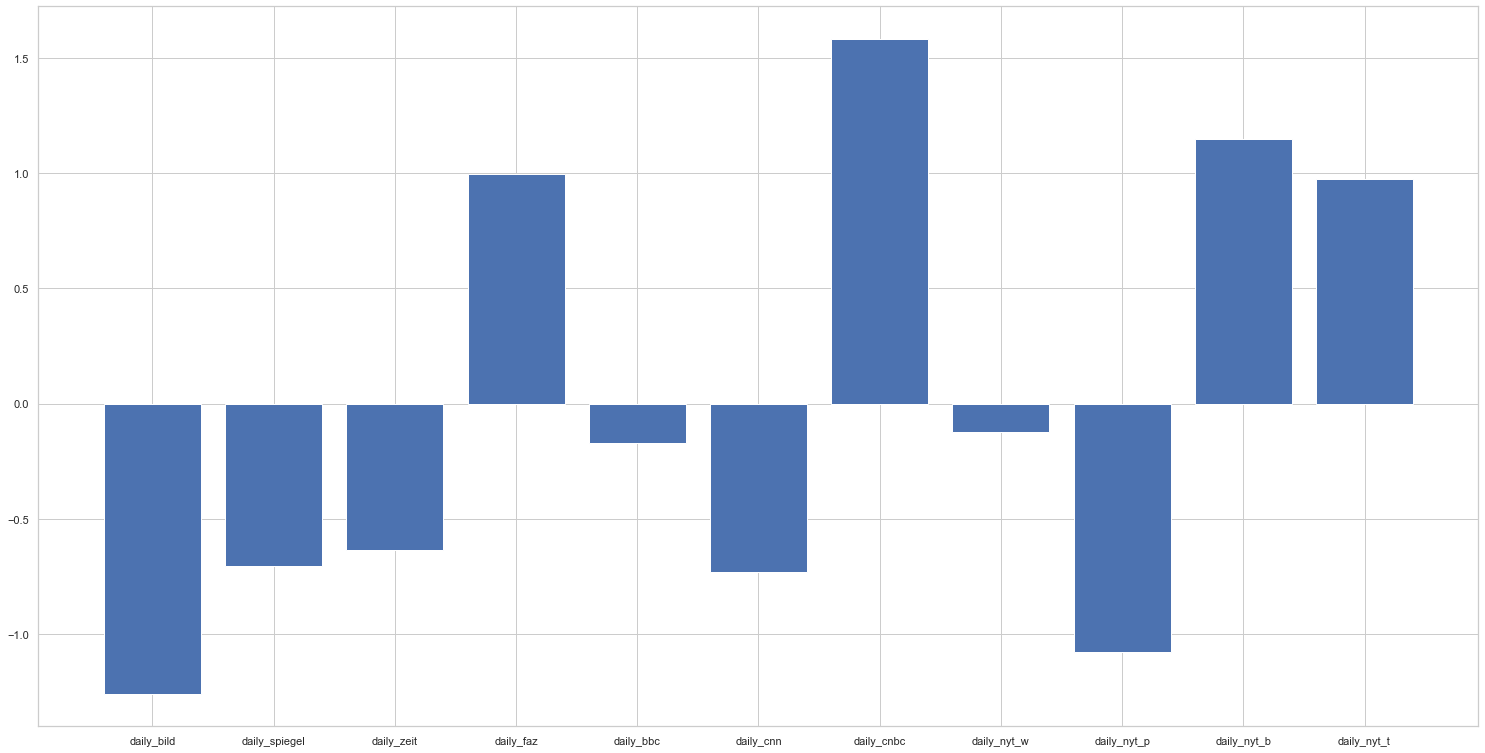

In [204]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
langs = ['daily_bild' , 'daily_spiegel', 'daily_zeit', 'daily_faz', 'daily_bbc', 'daily_cnn', 'daily_cnbc', 'daily_nyt_w', 'daily_nyt_p', 'daily_nyt_b', 'daily_nyt_t']
students = df_zscore["polarity"]
ax.bar(langs,students)
plt.show()

##### At this point this has no significance, because of its short time frame of one day
But it was expected, that 'Bild' is among the more negative connotation

# 3. Upload on our MySQL Database <a id="3"></a>

In [205]:
############### CONFIGURE THIS ###################
# Open database connection

# Credentials to database connection
user = 'sql7372795'
passw = 'tbd'
host =  'sql7.freemysqlhosting.net'
database = 'sql7372795'


# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=host, db=database, user=user, pw=passw))

In [206]:
daily_sentiment.columns = daily_sentiment.columns.astype(str)

In [207]:
daily_sentiment.to_sql('sentiment', engine, if_exists = 'append')

Now we could schedule daily parsing and uploads!

# 4. Adjustments on the pre-trained BERT model <a id="4"></a>

Next: Use of pre-trained BERT model and adjustments for the financial nomenclature

# 5. Final FinBERT Model <a id="5"></a>

# 6. Upload on our MySQL Database <a id="6"></a>

In [93]:
############### CONFIGURE THIS ###################
# Open database connection

# Credentials to database connection
user = 'sql7372795'
passw = 'inserthere'
host =  'sql7.freemysqlhosting.net'
database = 'sql7372795'


# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=host, db=database, user=user, pw=passw))

In [94]:
Database.columns = Database.columns.astype(str)

In [95]:
Database.to_sql('database', engine, if_exists = 'append', index=False)

# Thank you for completing this Notebook!

<hr>
<h5>
<p> <center>  <font color='gray'> Jupyter Notebook by </font> Jonas Gottal </center></p>
</h5>